# Task 1.7HD: Data Cleansing and Text Analysis Challenge

* **Name**: Tri Khuong Nguyen
* **Student number**: 224605002
* **Email address**: s224605002@deakin.edu.au
* I am an *undergraduate (SIT220)* student

## Abstract

This report includes importing the downloaded datasets from **Academia - StackExchange** site and converting their `.xml` format into the standardised `.csv` format for 5 data visualisations. To successfully create the charts, we prepare the data by applying data wrangling techniques such as merging and filtering data frames, handling missing values, calculating aggregates, and extracting keywords using regular expressions. In the end, we cover data privacy issues that arise from these activities and suggest solutions.

## Importing packages

* First, we must import the packages we will use throughout this task.

* `numpy` and `pandas` are used for executing numbers and data frames respectively while `matplotlib` and `seaborn` facilitate the creation of visualisations. `matplotlib.patheffects` is a sub-module for the stroke of text.

* For this task, we need to use the `xml.etree.ElementTree` as a crucial component in converting the `.xml` data files to `.csv` (details in next section).

* Our world map in this report needs `geopandas`, while the sentiment analysis demands the use of the `nltk` library (consists of the sentiment analyzer `SentimentIntensityAnalyzer` from `nltk.sentiment` module). The `wordcloud` module will help us create a word cloud as one of the visualisations.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import xml.etree.ElementTree as ET
import geopandas as gpd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud


$\rightarrow$ Next, we will load our data.


## Converting `.xml` data files to `.csv`

* We choose the [**Academia**](https://academia.stackexchange.com/) (from [**StackExchange**](https://stackexchange.com/sites?view=list#oldest)) as the site for analysing.

* The zipped data folder for *Academia* can be downloaded [here](https://archive.org/download/stackexchange/academia.stackexchange.com.7z)

* After downloading, we extract the folder to get the data files (`Badges.xml, Comments.xml, PostHistory.xml, PostLinks.xml, Posts.xml, Tags.xml, Users.xml, Votes.xml`). These are all in `.xml` format, and it will be much more convenient for us if they are converted into `.csv` since we can import them as data frames and use `pandas` to perform different operations. Therefore, we decide to write a function converting `.xml` to `.csv`, called `xml_to_csv`. This function takes in the `.xml` file (parameter `input_file`) and outputs the `.csv` equivalence (parameter `output_file`).

* In this function, first, we get the entire XML structure of `input_file` as a tree using the imported `ET` module (`ET.parse(input_file)`). The parsed `tree` from `Posts.xml` will look something like this (with each `<row/>` tag representing a row containing all of its attributes - e.g. `Id="1"` denotes the attribute's data `"1"` of the attribute's name `Id`):
```xml
<posts>
    <row Id="1" Title="Question 1" />
    <row Id="2" Title="Question 2" />
</posts>
```

* Subsequently, we get the root of this `tree` (the top-level element that consists of all rows or all `<row/>` tags - the root is `<posts>` in our example) - `root = tree.getroot()`.

* For the next step, we create `table` as a list containing all rows from `root`. We can add the rows to `table` by looping through each row in `root` (`for row in root`) and append its attributes to `table` (`table.append(row.attrib)`). `row.attrib` encompasses all attributes of that `row` where each attribute is denoted by its name-data pair (key-value pair) in a dictionary. With our example, the first `row` to be appended to `table` is `{'Id': '1', 'Title': 'Question 1'}`.

* The last step is converting `table` to a data frame (`df`) using `pd.DataFrame(table)` and saving `df` into a `.csv` file (named `output_file`) with `df.to_csv(output_file, index=False)` (`index=False` avoids adding an extra index column to our data frame).

* After defining the function, we can call it for every conversion to `.csv` of our 8 `.xml` data files. For example, `xml_to_csv("Posts.xml", "Posts.csv")` converts `Posts.xml` to `Posts.csv` and saves it in the current directory, and the same goes for the other data files.

In [7]:
# Function that converts `input_file` (XML) to `output_file` (CSV)
def xml_to_csv(input_file, output_file):
    # Parse the XML file
    tree = ET.parse(input_file)
    root = tree.getroot()

    # Extract data
    table = []
    for row in root:  # Each element is a row
        table.append(row.attrib)  # Extract attributes (key-value pairs)

    # Convert to DataFrame
    df = pd.DataFrame(table)
    # Save DataFrame to CSV
    df.to_csv(output_file, index=False)

# Convert XML files to CSV and save them in current folder
xml_to_csv("Badges.xml", "Badges.csv")
xml_to_csv("Comments.xml", "Comments.csv")
xml_to_csv("PostHistory.xml", "PostHistory.csv")
xml_to_csv("PostLinks.xml", "PostLinks.csv")
xml_to_csv("Posts.xml", "Posts.csv")
xml_to_csv("Tags.xml", "Tags.csv")
xml_to_csv("Users.xml", "Users.csv")
xml_to_csv("Votes.xml", "Votes.csv")


$\rightarrow$ We have the standardised data files in `.csv` format.


## Loading data files

* Having all converted `.csv` data files, we can load them into our notebook as data frames using `pd.read_csv()` for each.

In [10]:
# Load converted CSV files as pandas data frames
badges_df = pd.read_csv("Badges.csv")
comments_df = pd.read_csv("Comments.csv")
postHistory_df = pd.read_csv("PostHistory.csv")
postLinks_df = pd.read_csv("PostLinks.csv")
posts_df = pd.read_csv("Posts.csv")
tags_df = pd.read_csv("Tags.csv")
users_df = pd.read_csv("Users.csv")
votes_df = pd.read_csv("Votes.csv")


$\rightarrow$ We are now ready for the analysis part.


## World Map highlighting Top 5 Countries with most Users

* **Idea:** We want to create a World Map that colors each country's region based on its number of users (a color scale to map the number of users with the corresponding color). The names of the 5 countries with the most users are also displayed.

* In `users_df`, each row represents the information of a user and their country is mostly contained in the `Location` column (see [*User* table's columns](https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede)). The first thing we should do is removing the missing values in `Location` (`sub_users_df = users_df.dropna(subset=["Location"])` - `sub_users_df` is a sub data frame that we use specifically in this section to avoid altering the main `users_df` data frame).

* Since each cell in `Location` encompasses not just the country name but also state, city, etc., we must extract only the country name, which is achievable with [**regular expressions (regexes)**](https://docs.python.org/3/library/re.html) - a regex is essentially a standard pattern (form) of substring that we write to match every substring exists in a string. With that being said, we can convert the data in `Location` column to string (`sub_users_df["Location"].str`), then use `.extract()` and input the regex that grabs the country names. We start with `r`, an indication of regex, followed by the pattern (substring) inside `"( )"` (the parentheses group different expressions into a single pattern). The pattern for each country name is a word (`\w+` - `\w` starts from the first letter of the word and `+` matches remaining letters until the end of that word or until encountering a non-word character like a space, which means grabbing the whole word). At this point, we have grabbed `"Vietnam"` or `"China"`, but there are country names with more than one word (e.g. `"United States"`), so we must account for another word with an expression `(?:\s\w+)?` - `\s\w+` contains a space (`\s`) followed by a word (`\w+`), and if there is a space after the first word, there is a second word, so these must go together and be included in a non-capturing group (`(?: )` - basically not creating a new group in memory but this belongs to the only group we created initially as one group corresponds to the one `Location` column we are working on only); the `?` at the end specifies that this non-capturing group is optional (as there are countries with 1 word in their name only but there is an option to include the second word for 2-word names). There should also be an option for 3-word countries (`"Papua New Guinea", "United Arab Emirates", etc.`), and its expression is the same as the one for the second word (`(?:\s\w+)?`). The last important expression is the `$` sign, which only matches the substrings started from the end because as observed, most users typed their `Location` in the form `City, state, Country`, so the country names are likely at the end. We create a column `Country` that contains the extracted country names (assign the extracted column to `sub_users_df["Country"]`).

* The extracted names are quite accurate, except for users who did not include their country names but only the city or state names. To rectify these, we replace the city or state names that belong to each country with the country name itself. Starting with *USA*, we turn the created `Country` column into strings (`sub_users_df["Country"].str`), then use `.replace()` function with regex (`regex=True`) `\b` is the boundary (use `\b` at the beginning and the end of the group `()` shows that we only want to match the standalone names because without this, we might mistakenly alter a few letters in a meaningful name), `|` performs the logic *OR* (`us|usa|united states` matches either `us` or `usa` or `united states`). All substrings with this pattern (the created regex) should be changed to `"USA"`. Note that we set `case=False` to match the names case-insensitively (e.g. `usa` is the same as `Usa`). The [states of USA](https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#States) (e.g. NY - New York, IL - Illinois) should also be replaced by `USA`. Applying the same method for a few cities of some other countries: [UK](https://en.wikipedia.org/wiki/List_of_cities_in_the_United_Kingdom#List_of_cities), [Germany](https://en.wikipedia.org/wiki/List_of_cities_in_Germany_by_population#List), [Australia](https://en.wikipedia.org/wiki/List_of_cities_in_Australia), [China](https://en.wikipedia.org/wiki/List_of_cities_in_China_by_population#Cities_and_towns_by_population), [India](https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population#List), [Canada](https://en.wikipedia.org/wiki/List_of_cities_in_Canada), [France](https://simple.wikipedia.org/wiki/List_of_cities_in_France), [Italy](https://en.wikipedia.org/wiki/List_of_cities_in_Italy), [Spain](https://en.wikipedia.org/wiki/List_of_metropolitan_areas_in_Spain), [Brazil](https://en.wikipedia.org/wiki/List_of_cities_in_Brazil_by_population). Germany and Czech Republic are also called by other names in their native languages, like Deutschland and Czechia respectively, which also need to be replaced. After each invocation of the replace function, we assign the column with replaced names to the original one (in-place replacing) - `sub_users_df.loc[:, "Country"]`.

* We have now got the extracted and cleaned country names that we can utilise to create the map, but first, we must import the map itself from the [*Natural Earth dataset*](https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip) (contains countries and their shapes at 1:110 million scale) using `gpd.read_file(link_above)`. We call it `world_map`.

* The two country names `"United States of America"` and `"United Kingdom"` of the original `world_map` need to be modified to `"USA"` and `"UK"` respectively to match the ones in the `Location` column of `sub_users_df` (`world_map["NAME"] = world_map["NAME"].replace("United States of America", "USA")` and `world_map["NAME"] = world_map["NAME"].replace("United Kingdom", "UK")`, both are in-place replacements).

* We count the users (occurrences) of every unique country using `sub_users_df["Country"].value_counts()`, assigned to `countryUsers_counts`. We then take the country names of `world_map` (`world_map["NAME"]`) and map them with their corresponding counts (`countryUsers_counts`) with `world_map["NAME"].map(countryUsers_counts)`. Countries not present in the `Country` column are automatically assigned with 0 users in `world_map` (`.fillna(0)`). This mapping is the new column `countryUsers_counts` of the `world_map` data frame (`world_map["countryUsers_counts"]`).

* To the step of plotting the map, we first create the axes `ax` from `plt.subplots(1, 1, figsize=(15, 5))`, a single subplot with 1 row and 1 column, and figure size of 15 inches wide and 5 inches tall. Subsequently, we use `world_map.plot()` to draw the map, with the count of users of each country (`countryUsers_counts` column established in the previous step) as the data (`column="countryUsers_counts"`), using the created axes (`ax=ax`), the black border of each country for visual clarity (`edgecolor="black"`), the *"viridis"* color map that assigns a color in the color scale for each country region based on their count (`cmap="viridis"`), and `legend=True` displays the color scale. `ax.set_xticks([])` and `ax.set_yticks([])` remove the ticks on x- and y-axes respectively as they are unnecessary for this visualisation.

* To display the names of 5 countries with most users, we can first filter them using `countryUsers_counts.nlargest(5)`, and convert to a dictionary (`.to_dict()`) where each country name is the key and its corresponding count is the value. `world_map.geometry.centroid.x`, `world_map.geometry.centroid.y`, `world_map["NAME"]` are the x-coordinates of the country centroids (the centers of country regions), the y-coordinates of those country centroids, and those country names respectively, and if we use the `zip()` function on them, we have those 3 of each country in a tuple (belonged to an index) in a list of tuples (each tuple represents a country). Looping through the zipping of each country (with its centroid's x-coordinate as `x`, y-coordinate as `y`, name as `name`), if that country is one of the 5 countries with most users (`if name in top_5_countries`), we add display the name (`name`) right at the centroid (`x` and `y` coordinates) using `plt.text(x, y, name)`, with 7 as font size (`fontsize=7`), white as text color (`color="white"`), and a black stroke of width 2 (`path_effects=[path_effects.withStroke(linewidth=2, foreground="black")]`).

* For the final decorations, we add the title (`plt.title("World Map showing Number of Users for each Country")`), use bigger map (`plt.tight_layout()`), and show the map (`plt.show()`).


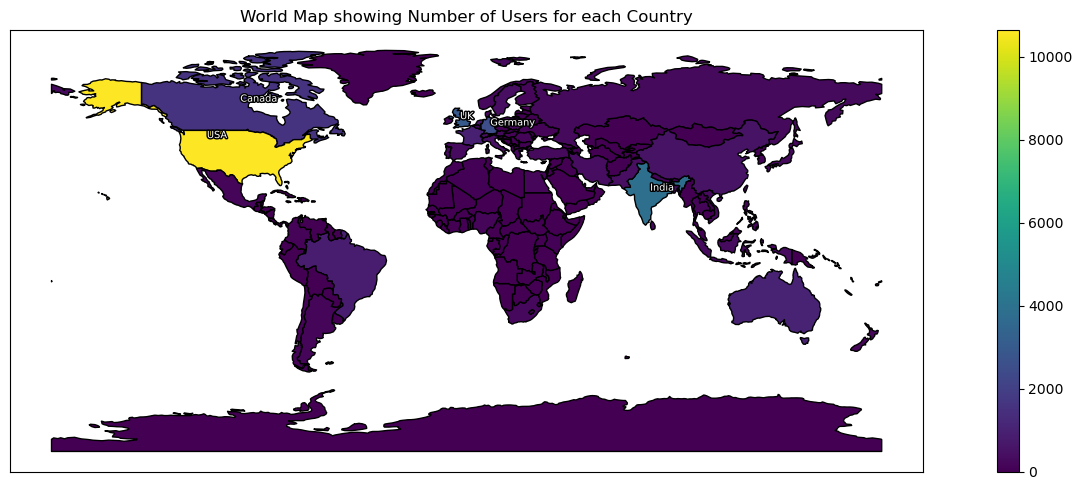

In [18]:
# Handle missing data
sub_users_df = users_df.dropna(subset=["Location"])

# Extract country names
sub_users_df["Country"] = (sub_users_df["Location"]
                           .str
                           .extract(r"(\w+(?:\s\w+)?(?:\s\w+)?$)")
                          )

# Replace names referring to single distinct country
## "USA"
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"\b(us|usa|united states)\b",
    "USA",
    case=False, regex=True
)
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"\b(NY|NM|NJ|NH|NV|NE|MT|MO|MS|MN|MI|MA|MD|"
    r"ME|LA|KY|KS|IA|IN|IL|ID|HI|GA|FL|DE|CT|CO|CA|AR|AZ|AK|AL|"
    r"NC|ND|OH|OK|OR|PA|RI|SC|SD|TN|TX|UT|VT|VA|WA|WV|WI|WY)\b",
    "USA",
    case=True, regex=True
)

## "UK"
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"\b(uk|united kingdom|london|manchester|birmingham|nottingham|"
    r"england|wales|cardiff|scotland|edinburgh|northern Ireland)\b",
    "UK", case=False, regex=True
)

## "Germany"
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"deutschland|munich|berlin|hamburg|cologne", "Germany",
    case=False, regex=True
)

## "Australia"
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"sydney|melbourne|canberra|perth|adelaide", "Australia",
    case=False, regex=True
)

## "China"
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"beijing|shanghai", "China", case=False, regex=True
)

## "India"
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"mumbai|chennai", "India", case=False, regex=True
)

## "Canada"
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"vancouver|toronto|ottawa|montreal|calgary", "Canada",
    case=False, regex=True
)

## "France"
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"paris", "France", case=False, regex=True
)

## "Italy"
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"rome|milan", "Italy", case=False, regex=True
)

## "Spain"
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"madrid|barcelona", "Italy", case=False, regex=True
)

## "Czech"
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"czechia", "Czech Republic", case=False, regex=True
)

## "Brazil"
sub_users_df.loc[:, "Country"] = sub_users_df["Country"].str.replace(
    r"brasil|brazil|rio de janeiro", "Brazil",
    case=False, regex=True
)


# Import the map
world_map = gpd.read_file("https://naciscdn.org/naturalearth/110m/"
                          + "cultural/ne_110m_admin_0_countries.zip")

# Replace country names
world_map["NAME"] = world_map["NAME"].replace("United States of America", "USA")
world_map["NAME"] = world_map["NAME"].replace("United Kingdom", "UK")

# Establish country counts and map them to the map
countryUsers_counts = sub_users_df["Country"].value_counts()
world_map["countryUsers_counts"] = (world_map["NAME"]
                                    .map(countryUsers_counts)
                                    .fillna(0)
                                   )

# Plot the map
_, ax = plt.subplots(1, 1, figsize=(15, 5))
world_map.plot(column="countryUsers_counts", ax=ax, edgecolor="black",
               cmap="viridis", legend=True)
ax.set_xticks([])
ax.set_yticks([])

# Add labels for the top 5 countries
top_5_countries = countryUsers_counts.nlargest(5).to_dict()
for x, y, name in zip(world_map.geometry.centroid.x,
                      world_map.geometry.centroid.y,
                      world_map["NAME"]):
    if name in top_5_countries:
        plt.text(x, y, name, fontsize=7, color="white",
                 path_effects=[path_effects.withStroke(linewidth=2,
                                                       foreground="black")]
                )

plt.title("World Map showing Number of Users for each Country")
plt.tight_layout()
plt.show()


$\rightarrow$ Via the colors and the annotations, the top 5 countries with most Academia users, from largest to smallest, are USA, India, UK, Germany, and Canada. This can be verified by printing out `top_5_countries`.


In [20]:
print(top_5_countries)

{'USA': 10640, 'India': 3859, 'UK': 2963, 'Germany': 2533, 'Canada': 1573}


$\rightarrow$ The USA takes the lead in this list by a significant gap. It has 10640 users, which is 6781 more than the second-ranked country. This is quite obvious considering there were 4 USA universities in top 10 of [QS World University Rankings 2024](https://www.topuniversities.com/world-university-rankings/2024) (as our datasets were recorded up until 2024), with MIT taking top 1. This is the ranking that focuses on the academic aspect, weighing metrics such as [Academic Reputation](https://support.qs.com/hc/en-gb/articles/4405952675346-Academic-Reputation-Indicator), [Citations per Faculty](https://support.qs.com/hc/en-gb/articles/360019107580-Citations-per-Faculty-Indicator), and [International Research Network](https://support.qs.com/hc/en-gb/articles/360021865579-International-Research-Network-Indicator). India (3859 users), despite [not having universities in top 100 of QS Ranking](https://www.topuniversities.com/world-university-rankings/2024?countries=in), it is still the origin of numerous excellent researchers and academia enthusiasts working and studying overseas. Four of the UK (2963 users) universities are in top 10 of QS Ranking 2024, demonstrating a strong academic background of students from those institutions. Germany (2533 users) also has many research-based education providers with [4 universities in top 100 of QS Ranking 2024](https://www.topuniversities.com/world-university-rankings/2024?countries=de). Canada (1573 users) is ranked fifth in the number of Academia users, having [3 universities in top 100 of QS Ranking 2024](https://www.topuniversities.com/world-university-rankings/2024?countries=ca).

## Radar chart showing people with Student, Teacher, Scholar badges their Reputation and casted Upvotes, Downvotes

* **Idea:** Our second visualisation is a radar chart with 3 attributes: *Upvotes*, *Downvotes*, *Reputation*. In *Academia* site, via the [Badges information](https://academia.stackexchange.com/help/badges) a *Student* badge is given to a person with their question having at least a score of 1, *Scholar* for the one that asks a question and accepts an answer, *Teacher* for the one that answers a question with a score of 1 or more. We want to visualise on the radar chart each of these badges to see how they interact with the community (casting *Upvotes* and *Downvotes*) and how the community interacts with them (them gaining *Reputation*).

* We need `UpVotes`, `DownVotes`, and `Reputation` columns from `users_df` and `Name` column (name of the badge) from `badges_df`. Both these data frames can be merged on the user ID column, which is the `Id` column in `users_df` and `UserId` column in `badges_df`, so we have to rename one of them to match the other - we choose to rename in-place the one in `users_df` (`users_df.rename(columns={"Id": "UserId"}, inplace=True)`). Then, proceed with the merge operation `users_df.merge(badges_df, on="UserId")` and select the necessary columns (`[["Name", "Reputation", "UpVotes", "DownVotes"]]`). The merged data frame is called `badges_users_df`.

* Next, we filter `badges_users_df` to only include the users having our targetted badges (`badges_users_df[badges_users_df["Name"].isin(["Student", "Teacher", "Scholar"])]` - the `Name` columns only consists of either `Student`, `Teacher`, or `Scholar`; and rewrite `badges_users_df`).

* Based on the [Reputation interpretation](https://academia.stackexchange.com/help/whats-reputation), it is increased by 10 for a user if their question or answer is upvoted, so it is a large difference visualising *Reputation* and *Upvotes* in a single chart, thus it is best that we normalise *Reputation* to the number of upvotes a user receives by dividing it by 10 (`badges_users_df["Reputation"] /= 10` - this also means converting *Reputation* to the same scale as *Upvotes*).

* Our main data for the chart `radial_data` is prepared by grouping users with `Student` badge (also `Teacher` and `Scholar` groups), which can be performed using `badges_users_df.groupby("Name")`. We then select the 3 specified attributes (3 columns - `[["Reputation", "UpVotes", "DownVotes"]]`) and take the average (`.mean()`) `Reputation`, `UpVotes`, `DownVotes` for each group (`Student`, `Teacher`, `Scholar`).

* To create the chart, we first generate its axes (`ax`), which is a subplot `plt.subplots()` with figure size *5 x 5 inches* (`figsize=(5, 5)`), using the earth's polar projection similar to the radar's shape (`subplot_kw={"projection": "polar"}`). `colors` contains 3 distinct colors (for `Student`, `Teacher`, `Scholar`) from the color map `viridis` - `plt.cm.get_cmap("viridis", 3)`. The 3 attributes (`Reputation`, `UpVotes`, `DownVotes`) are evenly distanced in the circle (radar), and those positions can be generated from `np.linspace(0, 2 * np.pi, 3, endpoint=False)` (a circle from angle $0$ to $2\pi$, each position is separated from another with a distance of a circle divided by $3$, and `endpoint=False` excludes $2\pi$ because including it results in a redundant position after 3 positions $0, 2\pi/3, 4\pi/3$). Converting into a list (`.tolist()`) helps us manipulate this easier. This list is `positions`. To complete the circle, we return to the first angle by appending it to our list (`positions.append(positions[0])`).

* To draw the values computed in `radial_data`, we loop through each of its rows (`enumerate(radial_data.iterrows())`), extracting the index (`idx`) and group's name with group's attributes (`(grp_name, grp_atts)`) as a row represents a group. `att_values` is a list of average `Reputation`, `UpVotes`, `DownVotes` values (from `grp_atts.values.tolist()`) of the corresponding group `grp_name`. Similar to `positions`, we also append the first value to `att_values` to complete the circle (`att_values.append(att_values[0])`). We can then draw 3 dots on 3 positions representing 3 values (the larger the value, the further it is from the origin) by plotting the values (`att_values`) on their respective positions (`positions`) using `ax.plot(positions, att_values)`, with name appearing in legends (`label=grp_name`), color for the line connecting 3 dots is one in the created `colors` list (`color=colors(idx)`). We fill the shape drawn by the lines with `ax.fill(positions, att_values, color=colors(idx), alpha=0.25)` (use the same color as the lines but with 25% opacity - `alpha=0.25`). We just drew, for example, the data of `Student`; `Teacher` and `Scholar` are drawn using the same approach (which should be since we are looping through every group).

* The largest circle is the x-axis, and we want to display the attribute names on it at `positions` (`ax.set_xticks(positions[:-1])` - excluding the last one that we appended as we only need 3 positions, not completing the circle). After setting the positions, we display the names with `ax.set_xticklabels(["           Reputation", "Upvotes", "Downvotes"])`. `radial_data.max()` creates a list of maximum values, each from a column of `radial_data`, and `.max()` picks the largest from those maximum values, this is essentially the largest value presented in our data and is used as the radius of the largest circle (`max_val`). There are 4 circles, the smallest has a radius of $1/4$ of `max_val`, then $2/4$, $3/4$, $4/4$, that is why we have a list of radiuses (`[max_val * i / 4 for i in range(1, 5)]`) and also our `y-ticks` on the y-axis. The positions of y-ticks are set using `ax.set_yticks(y_ticks)`, and the values are printed using `ax.set_yticklabels([f"{int(tick)}" for tick in y_ticks], fontsize=8)` (basically the integer values of radiuses, with `8` as font size). `ax.set_ylim(0, max_val)` ensures the entire chart from radius `0` to radius `max_val` fits in the plot. We can add a legend box denoting the groups on the upper right of the plot at coordinates `(1.3, 1)` (avoid overlapping) with `ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))`, and a title with `plt.title("Radar Chart visualising Upvotes, Downvotes, Reputation for Student, Teacher, Scholar")`.

* Lastly, we display the chart with `plt.show()`.

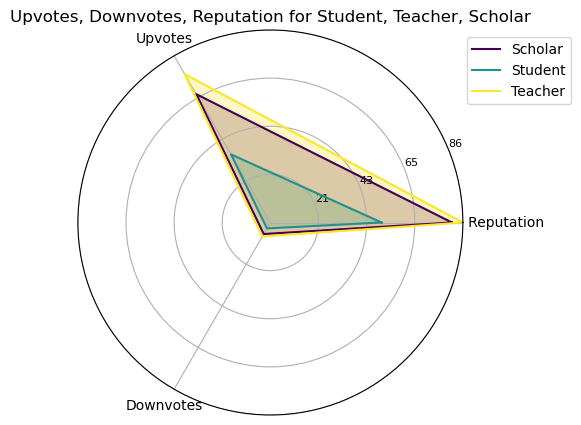

In [23]:
# Merge
users_df.rename(columns={"Id": "UserId"}, inplace=True)
badges_users_df = (users_df
                   .merge(badges_df, on="UserId")
                   [["Name", "Reputation", "UpVotes", "DownVotes"]]
                  )

# Filter data frame to include only "Student", "Teacher", "Scholar"
badges_users_df = badges_users_df[badges_users_df["Name"]
                                      .isin(["Student", "Teacher", "Scholar"])
                                 ]

# Adjust Reputation to the same scale as other attributes
badges_users_df["Reputation"] /= 10

# Compute average Reputation, Upvotes, Downvotes of each Student, Teacher, Scholar
radial_data = (badges_users_df
               .groupby("Name")
               [["Reputation", "UpVotes", "DownVotes"]]
               .mean()
              )

# Create plot, axes
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "polar"})
colors = plt.cm.get_cmap("viridis", 3)
positions = np.linspace(0, 2 * np.pi, 3, endpoint=False).tolist()
positions.append(positions[0])

# Drawing the values
for idx, (grp_name, grp_atts) in enumerate(radial_data.iterrows()):
    att_values = grp_atts.values.tolist()
    att_values.append(att_values[0])
    ax.plot(positions, att_values, label=grp_name, color=colors(idx))
    ax.fill(positions, att_values, color=colors(idx), alpha=0.25)

# Add attribute names
ax.set_xticks(positions[:-1])
ax.set_xticklabels(["           Reputation", "Upvotes", "Downvotes"])
# Define y-tick values (radiuses)
max_val = radial_data.max().max()
y_ticks = [max_val * i / 4 for i in range(1, 5)]
# Add y-ticks
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{int(tick)}" for tick in y_ticks], fontsize=8)
ax.set_ylim(0, max_val)
# Add legend, title
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title("Upvotes, Downvotes, Reputation for Student, Teacher, Scholar")

# Display chart
plt.show()


$\rightarrow$ Users with *Teacher* badge have the highest Reputation score. They actively answered the questions posted on the site to receive many upvotes from others, thus gaining Reputation (average score of 86 - in our chart, receiving 1 Upvote corresponds to increasing the Reputation score by 1). For *Scholar* and *Student*, the Reputation scores are 80 and 50 (roughly) respectively. This might be due to the fact that they did not answer as many questions as *Teacher*-badge people, or the questions they replied to were not well-answered enough so those replies only received a few Upvotes. With this in mind, it seems that *Teacher*-badge users are the ones with broad knowledge as knowing a wide range of topics and insights helped them answer the questions on the spot. This not only leads to them receiving a lot of Upvotes to gain high Reputation score, but also facilitates their understanding of other posts, casting an average of about 75 Upvotes, while that of *Scholar* and *Student* are just over 65 and 33 Upvotes. However, their thorough comprehension of content also results in them evaluating posts more strictly, casting more Downvotes than *Scholar* and *Student*, although the gaps between them are narrow in this metric, with each of them downvoting an average of less than 10 posts. From the last two metrics, we can see that the Academia community is pretty friendly, polite, and generous as they often upvote instead of downvoting. Overall, *Teacher* users possess the highest scores in all 3 attributes, indicating their frequent interaction with other people (casting Upvotes and Downvotes) and the agreement from the community that they received (gaining high Reputation score). *Scholar* people are quite close to *Teacher* in the 3 metrics but *Student*. Since this is an Academia site, an environment with mostly research-related content, it is understandable that most users are doctors of philosophy or professors, and are the owners of *Teacher* badge.


## Bubble chart illustrating Number of Posts and Upvotes for each Question Type in *5W1H*

* **Idea:** Our third visualisation is a bubble chart encompassing 6 bubbles, each represents a type of question in [*5W1H*](https://safetyculture.com/topics/5w1h/). For instance, the *How* bubble's size visualises the number of *How* questions posted on the site, and its color (mapped to a color scale) visualises the total number of upvotes for all *How* questions.

* `posts_df` and `votes_df` are the data frames that we use in this section. Similar to the radar chart's data, we must rename `posts_df`'s `Id` column to `PostId` in order to match `PostId` column in `votes_df` for the merging purpose (`posts_df.rename(columns={"Id": "PostId"}, inplace=True)`).

* To identify the question type in each question, we use regular expression on the `Title` column of `posts_df` (`posts_df["Title"].str.extract(r"\b(What|Who|Which|Where|Why|How)\b")` - extracting one of the *What, Who, Which, Where, Why, How* but only the separated words so `\b` at the beginning and the end). The extraction is stored in a newly created column `QuestionType` (`posts_df["QuestionType"]`).

* Getting the number of upvotes for all posts belonging to a question type is a little complicated, so we get the number of upvotes for each post first. This can be done with filtering `votes_df` to contain only the upvote rows - `votes_df[votes_df["VoteTypeId"] == 2]` ([`VoteTypeId = 2` means an upvote](https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede)). There can be, for example, 2 records of the same `PostId` in `votes_df`, and they both have `VoteTypeId = 2`, that means a post receives 2 upvotes. As we have filtered `votes_df` to have only upvoting records, we can create unique `PostId` groups (`.groupby("PostId")`) and count the upvotes (the records) of each group (`.size()`). The count column is called `Upvotes` (`.rename("Upvotes")`).

* After deriving the needed columns for `posts_df` and `votes_df`, we can merge them on matching `PostId` (`posts_df.merge(votes_df, on="PostId")`). The merged data frame is `posts_votes_df`.

* For the counts of question types, we group each of them (`.groupby("QuestionType")`) from the merged `posts_votes_df` and count the number of posts in each (`.size()`), this results in a Series `type_count`. For the number of upvotes of each question type, we also create groups of question types, but instead of counting the instances of each group, we take the sum of upvotes from these instances (`["Upvotes"].sum()`), this results in a Series `type_upvotes`.

* To create the bubble chart, we first generate axes (`ax`) for it from `plt.subplots()` with the figure size *14 x 4* inches (`figsize=(14, 4)`). `question_types` is a list of all question types `["What", "Who", "Which", "Where", "Why", "How"]` that will be useful later.

* The bubbles representing question types (sorted in order as specified in `question_types` list). Their sizes are stored in a list named `sizes`. This list is constructed by grabbing each type (`q_type`) sorted in order (`for q_type in question_types`), getting its count (number of questions) from `type_count` (`type_count.get(q_type)`) and multiplying by 2 just for scaling (`* 2`) because we do not want our bubbles to be too small. The colors of bubbles are stored in `colors`, each (`q_type`) is determined by its corresponding number of upvotes (`type_upvotes.get(q_type)`).

* Our chart is named `bubbles`, created from `ax.scatter()` with the question types (`question_types`) as the x-axis labels, and for the y-axis labels, they are `[1] * 6` (6 bubbles having the same y-coordinate - horizontally aligned). They, from left to right, use the established `sizes` and `colors` (`s=sizes, c=colors`), and all have black outline (`edgecolors="black"`). We use the `plasma` color scale mapped with `c=colors` (`cmap="plasma"`).

* We add a color bar for our `bubbles` chart for referencing the number of upvotes (`plt.colorbar(bubbles, label="Upvotes")`). As for the number of posts of each bubble, we add a text right below it. This is performed by looping through each index `i` (`for i in range(6)` as there 6 bubbles). For each i-th bubble, we write the text below it (`ax.text(i, 0.96)` - at x-coordinate `i` and y-coordinate `0.96`, the same for all bubbles as they are also horizontally aligned). The content of the text is `f"Posts: {sizes[i]//2}"` (dividing each size by 2 to get the correct count since we previously upscaled them for visualising purposes). `ha="center"` puts the text at the center, right below its bubble, and with `10` as font size (`fontsize=10`).

* The x-axis labels are the question types themselves (`ax.set_xticks(question_types)`) and the x-axis title is *"Question Type"* (`ax.set_xlabel("Question Type")`). `ax.set_xlim(-1, 6)` expands the left edge of the plot to x-coordinate `-1` and the right edge to `6` to ensure the first and last bubbles are fully contained inside. We want a blank y-axis so `ax.set_yticks([])`. `ax.set_title("Question Types: Number of Questions and Number of Upvotes")` for customising the chart title.

* Finally, we can easily display the chart with `plt.show()`.

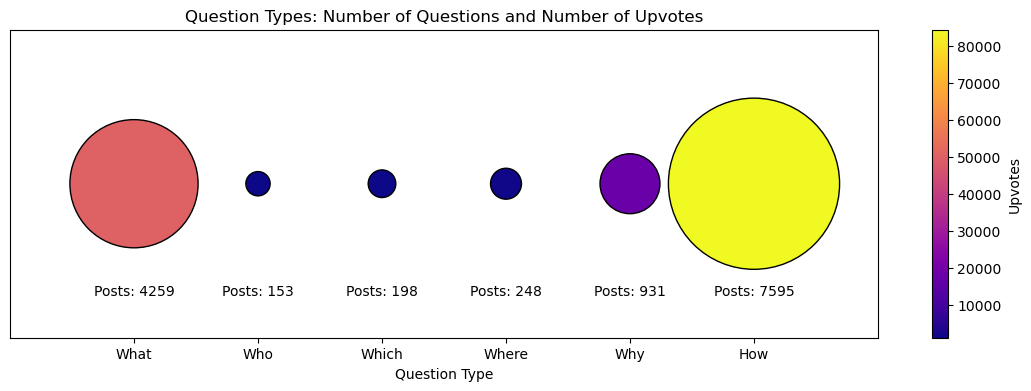

In [26]:
# Rename posts_df's column to match votes_df
posts_df.rename(columns={"Id": "PostId"}, inplace=True)

# Regex to extract question type
posts_df["QuestionType"] = (posts_df["Title"]
                            .str
                            .extract(r"\b(What|Who|Which|Where|Why|How)\b")
                           )

# Filter votes_df to contain only upvote rows (VoteTypeId=2)
votes_df = (votes_df
            [votes_df["VoteTypeId"] == 2]
            .groupby("PostId")
            .size()
            .rename("Upvotes")
           )

# Merge posts_df with votes_df
posts_votes_df = posts_df.merge(votes_df, on="PostId")

# Count and number of upvotes for each type
type_count = posts_votes_df.groupby("QuestionType").size()
type_upvotes = posts_votes_df.groupby("QuestionType")["Upvotes"].sum()

# Create the plot
_, ax = plt.subplots(figsize=(14, 4))

# List of question types
question_types = ["What", "Who", "Which", "Where", "Why", "How"]

# Lists of bubble sizes and their respective colors
sizes = [type_count.get(q_type) * 2 for q_type in question_types]
colors = [type_upvotes.get(q_type) for q_type in question_types]

# Draw the bubbles
bubbles = ax.scatter(question_types, [1] * 6, s=sizes, c=colors,
                     edgecolors="black", cmap="plasma")

# Add color bar and number of questions of each type
plt.colorbar(bubbles, label="Upvotes")
for i in range(6):
    ax.text(i, 0.96, f"Posts: {sizes[i]//2}", ha="center", fontsize=10)

# Customise the axes and chart title
ax.set_xticks(question_types)
ax.set_xlabel("Question Type")
ax.set_xlim(-1, 6)
ax.set_yticks([])
ax.set_title("Question Types: Number of Questions and Number of Upvotes")

# Display chart
plt.show()

$\rightarrow$ The most prominent insight of chart is the more posts there are of a question type, the more upvotes that question type gets. This is the same as saying you receive more upvotes if you post more. While it seems to be true for most question types, the pair *Who* and *Which* contradicts this. We verify this by printing out the number of upvotes for each question type (the `type_upvotes` Series):

In [28]:
print(type_upvotes)

QuestionType
How      84365
What     50045
Where     1832
Which     1265
Who       1338
Why      18124
Name: Upvotes, dtype: int64


$\rightarrow$ *Who*, with only 153 posts compared to 198 posts of *Which*, but with 1338 total upvotes, it surpasses *Which* (1265 upvotes). Above these two, we have *Where* with 248 posts and 1832 upvotes. The three most common types of questions are *How* (7595 posts and 84365 upvotes), *What* (4259 posts and 50045 upvotes), and *Why* (931 posts and 18124 upvotes). We are interested in having a thorough understanding of the discrepancy between *How* and *Why* as they need people to elaborate on the questions for detailed answers, creating intriguing discussions on the Academia site. We can do this by printing the content of a few posts of each type. Starting with *How*, we filter the rows with `posts_votes_df[posts_votes_df["QuestionType"] == "How"]` and print retrieve the column `["Title"]` (we use `pd.set_option('display.max_colwidth', None)` before that to display the full text of each post).

In [30]:
pd.set_option('display.max_colwidth', None)
posts_votes_df[posts_votes_df["QuestionType"] == "How"]["Title"]

15                                                                                                    How do I select a graduate program?
19                                                                                  How many physician-scientists pursue academic tracks?
74                                                              University rank/stature - How much does it affect one's career post-Ph.D?
82                                                                                             How do you judge the quality of a journal?
98                                                                                  How to find a good topic for a PhD research proposal?
                                                                       ...                                                               
134696    How do I reframe getting an MPhil instead of a PhD the first time round, in the context of applying for a mathematical postdoc?
134750                            

$\rightarrow$ *How* questions focus on solving specific problems, and there are various in different environments, not just in Academia. In this field, one bachelor's degree receiver may ask *"How do I select a graduate program?"* to embark on a new part of their academic journey. *"How to find a good topic for a PhD research proposal?"* might be the enquiry of a student looking for the topic of their PhD thesis. For teachers, the lack of students in their classes is perhaps the reason for the question *"How do I motivate my PhD students to attend seminars?"*.

$\rightarrow$ We can apply the same method to extract the *Why* questions:

In [32]:
posts_votes_df[posts_votes_df["QuestionType"] == "Why"]["Title"]

652                                                                                               Why don't researchers publish failed experiments?
801                                                                                         Why do universities place a weight on GRE/TOEFL scores?
1050                                                                                              Why does professor prohibit me talking to people?
1084                                                                       Why do so few universities offer OpenCourseWare videos of their lessons?
1184                                                                                           Why do universities have to spend money on journals?
                                                                            ...                                                                    
134161                                        Why do most US regional colleges/universities/institutions have po

$\rightarrow$ These questions primarily express curiosity on certain aspects in academia, like *"Why don't researchers publish failed experiments?"*. The question *"Why do a lot of publications ignore better results from other papers compare only to old results (example in deep learning and biomed)?"* was probably coming from a person who was pursuing research work in deep learning or biomedical science and they were confessing their worries on the unfairness of academia.

## Combo chart (line and scatter) visualising Top 3 Highest and Top 3 Lowest Days of Average Comments' Sentiment Scores

* **Idea:** For this one, we will analyse the sentiment of every comment posted on Academia site, find the average sentiment score of each day, and plot the 3 days with the highest sentiment scores and 3 days with the lowest ones on a line chart. Besides the main line showing the average scores, there will also be the scores of individual comments for each selected day shown on the chart.

* To start with, we use regular expressions to extract the creation date of each comment. Values in the `CreationDate` column of `comments_df` are in the form *YYYY-MM-DDThh:mm:ss*. Each date is presented by the first 10 letters (8 digits and 2 hyphens). The first 4 digits (*YYYY*) are grabbed with `\d{4}` in regex (`\d` tag stands for digit), then a hyphen `-`, and the next 2 digits (`\d{2}` - *MM*), another hyphen `-`, and the last 2 digits (`\d{2}` - *DD*). The extractions are put in the created `Date` column of `comments_df`.

* To analyse the sentiment of each comment, we first need to initialise the analyser `SentimentIntensityAnalyzer()` and name it as `sent_analyser`. The comments are stored in the `Text` column of `comments_df`, so we can analyse each of them using `comments_df["Text"].apply()`, inputting each `text` as each comment (`lambda text:`) into `sent_analyser.polarity_scores()`, and get the `compound` score of each (considering all the negative, neutral, positive sentiments of each comment into measurement; we use this type of score as it gives a holistic view of the comments). The scores are stored in the new `SentimentScore` column of `comments_df`.

* Now that we have had the sentiment scores, we can group them by date (`comments_df.groupby("Date")["SentimentScore"]`) and calculate the daily average sentiment (average sentiment of each day - `.mean()`). The resulting Series is called `daily_avg_sentiment`.

* To identify the 3 dates with highest sentiment scores, we use `.nlargest(3)` on the computed Series `daily_avg_sentiment`, then retrieve the dates into `top_3_dates` using `.index`. Same thing applies for the 3 dates with lowest sentiment scores (`bottom_3_dates` - `daily_avg_sentiment.nsmallest(3).index`). Then, we combine these two into a Series of selected dates (`selected_dates`), including top 3 and bottom 3 dates (`top_3_dates.union(bottom_3_dates)`).

* After getting the needed dates, we can filter our `comments_df` to only contain the data of these dates (`comments_df[comments_df["Date"].isin(selected_dates)]` - filter rows where dates of `Date` column is in `selected_dates`). We call the filtered data frame `selected_data`.

* The line chart needs the dates to be ordered, so we must sort them by converting the dates of `Date` column of `selected_data` into *datetime* format (`pd.to_datetime(selected_data["Date"])`), then sorting the dates in-place (`selected_data.sort_values("Date", inplace=True)`). After sorting, we convert these values back to string format for visualising purposes using `selected_data["Date"].dt.strftime('%Y-%m-%d')` (`%Y, %m, %d` grabs year, month, day respectively, separated by hyphens).

* Just like the calculation of daily average sentiment score that we implemented before, but this time instead of computing the data for all days (`comments_df`), we only consider the data of 6 chosen days and sorted by dates (`selected_data`). After grouping and calculating the average, the `Date` column is set as the index column, so we must use `.reset_index()` to put `Date` back to be a normal column that needs to be used as the x-axis of our chart. The computed data frame is called `avg_data`.

* To create the plot, we use `plt.figure(figsize=(10, 4))` (a figure of size *10 x 4* inches). The line of daily average sentiment is drawn from `sns.lineplot(x="Date", y="SentimentScore", data=avg_data)`, using the computed data (`data=avg_data`) with its `Date` column as the x-axis (`x`) and `SentimentScore` column as the y-axis (`y`), customising the line width (`linewidth=2`), line color (`color="black"`), and the label that appears in the legend box (`label="Daily Average"`). For the individual sentiment scores (points), we use `sns.scatterplot(x="Date", y="SentimentScore", data=selected_data, s=20`, with data of individual selected days before grouping as the data source (`data=selected_data`), the x-axis as well as y-axis are the same as the average line (`x="Date", y="SentimentScore"`), and the size of each point (`s=20`).

* We add a grey dashed line *y = 0* to mark the point where the sentiment is neutral, so all points representing comments above it are classified as positive, below it are negative, and on it are neutral. This line is created by `plt.axhline(0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)` (line *y = 0* - `0`, grey as color - `color="gray"`, dashed line style - `linestyle="--"`, line width - `linewidth=0.8`, and 70% opacity - `alpha=0.7`). We customise the x-axis and y-axis titles with `plt.xlabel("Date")` and `plt.ylabel("Sentiment Score")` respectively. A legend denoting the average line is added using `plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))` (at the top right corner - `loc="upper right"`, at position that avoids overlapping with the chart - `bbox_to_anchor=(1.3, 1)`).

* Finally, we set a title for our chart (`plt.title("Top 3 Highest and Top 3 Lowest Days of Average Comments' Sentiment Scores")`) and display it (`plt.show()`).

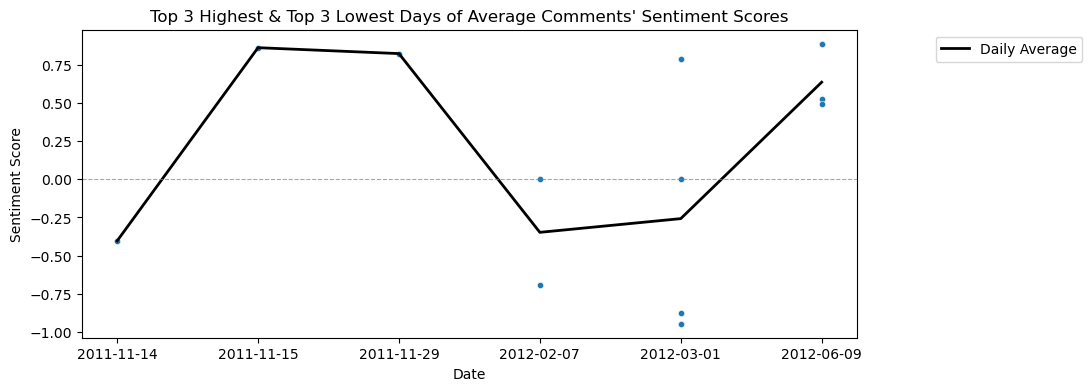

In [35]:
# Extract date using regex
comments_df["Date"] = (comments_df["CreationDate"]
                       .str
                       .extract(r"(\d{4}-\d{2}-\d{2})"))

# Calculate sentiment scores
sent_analyser = SentimentIntensityAnalyzer()
comments_df["SentimentScore"] = (comments_df["Text"]
                                 .apply(lambda text:
                                        sent_analyser.polarity_scores(text)
                                        ["compound"])
                                )

# Calculate daily average sentiment score
daily_avg_sentiment = comments_df.groupby("Date")["SentimentScore"].mean()

# Identify top 3 highest and lowest sentiment days
top_3_dates = daily_avg_sentiment.nlargest(3).index
bottom_3_dates = daily_avg_sentiment.nsmallest(3).index
selected_dates = top_3_dates.union(bottom_3_dates)

# Filter data for selected days
selected_data = comments_df[comments_df["Date"].isin(selected_dates)]

# Sort by date
selected_data["Date"] = pd.to_datetime(selected_data["Date"])
selected_data.sort_values("Date", inplace=True)
selected_data["Date"] = selected_data["Date"].dt.strftime('%Y-%m-%d')

# Data frame of daily average sentiment
avg_data = selected_data.groupby("Date")["SentimentScore"].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 4))

# Draw line for daily average sentiment score
sns.lineplot(x="Date", y="SentimentScore", data=avg_data,
             linewidth=2, color="black", label="Daily Average")

# Draw scatter points for individual sentiment scores
sns.scatterplot(x="Date", y="SentimentScore", data=selected_data, s=20)

# Customise the plot
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title("Top 3 Highest & Top 3 Lowest Days of Average Comments' Sentiment Scores")

# Display the chart
plt.show()

$\rightarrow$ From 2011 to 2024, the 3 days with highest comments' sentiment scores were *2011-11-15*, *2011-11-29*, and *2012-06-09*, while *2011-11-14*, *2012-02-07*, and *2012-03-01* were the 3 lowest days. We can examine the 3 highest days using the following code:

In [37]:
(selected_data[selected_data["Date"]
               .isin(["2011-11-15", "2011-11-29", "2012-06-09"])
              ]
              [["Text", "Date", "SentimentScore"]])

,Text,Date,SentimentScore
1513,"For publicly available data, transparency would dictate that code should go from the ""raw data"" that is publicly available to the fully transformed data. If not available via internet, it should be posted. The one ""downside"" to having to make data and data transformations public is that it lowers the reward to cleverly compiling/cleaning data sets if you don't have a monopoly on using them. As for confidentiality, researchers must respect confidential or proprietary data. However, in that case they should provide ""example data"" so that you can understand how the code worked.",2011-11-15,0.8625
1466,"This answer reminds me of Richard Dawkins' description of the height of trees in a forest. The population of trees would benefit if the average height were lower but because each individual tree benefits from being taller than average, the genes for greater height spread. The size of the redwood forests does not bode well for the prospect of future grade inflation.",2011-11-29,0.8238
2304,"I always tell my students to include the line ""My advisor Jeff Erickson suggested that I write to you."" _and_ to CC me on the email, so that the recipient sees that I can see that the student is name-dropping me, strongly implying that the student is telling the truth. (Also, I have spent the last several years building up an immunity to iocaine powder.)",2012-06-09,0.5267
2305,"""Personal communication"" is what you write when you've given up on citing anything that could actually help the reader, and just want to give credit to your friend. Which is about as much as citing a presentation accomplishes.",2012-06-09,0.8885
2306,Do you care more about learning stuff or making believe others that you are learning?,2012-06-09,0.4939


$\rightarrow$ *2011-11-15* and *2011-11-29* were the two days with only one comment each, and these comments got very high sentiment scores, *0.8625* and *0.8238* respectively. The former states the best practices in research data sharing, addressing its importance, downside, and confidentiality, and suggesting using example data. The latter while criticising grade inflation, did it in a respectful manner, expressing humor and avoiding negativity. The comment that received the highest sentiment score in our analysis (*0.8885*) came on the *2012-06-09*, it confessed the similar emotions of people when encountering a relatable situation like *"given up"*.

$\rightarrow$ For the 3 lowest days:

In [39]:
(selected_data[selected_data["Date"]
               .isin(["2011-11-14", "2012-02-07", "2012-03-01"])
              ]
              [["Text", "Date", "SentimentScore"]])

,Text,Date,SentimentScore
1512,"Publishing code is one thing, but what about the data? If you are using publicly available data, then there should be no excuse for not being transparent. But what about those who are working with confidential datasets?",2011-11-14,-0.4039
2872,"[Mendeley](http://www.mendeley.com/) has the groups feature, but I don't think that there is a discussion feature.",2012-02-07,0.0000
2873,"You can hold a discussion in a Mendeley group, but not specifically about one paper, and the interface is lousy (think Facebook wall).",2012-02-07,-0.6956
424,"In particular, do you mean personal troubles (like anxiety or depression or impostor syndrome) or professional troubles (like administrative hurdles or paper rejections or an irresponsible advisor)?",2012-03-01,-0.9468
425,See [this related question](http://cstheory.stackexchange.com/questions/3111/funny-tcs-related-papers-etc) on the theoretical computer science SE site. (Warning: lots of inside baseball.),2012-03-01,0.0000
426,Professional troubles. But also personal troubles that arise out of professional troubles too.,2012-03-01,-0.8750
427,Given all of the suggestions to utilize text searches more effectively I might have to expand my tool-box. Thank you for the insight.,2012-03-01,0.7902


$\rightarrow$ The only comment on *2011-11-14* was very negative (a negative sentiment score of *-0.4039*) as it crucified the post owner for not publishing the data used for the code, uncomplying with the transparency standard. Some other negative comments were, in fact, wrongly measured by our `SentimentIntensityAnalyzer()` model, for instance, the one on *2012-03-01* with the word *"troubles"* scored *-0.875*, or another one on the same day scored *-0.9468* (the lowest of all) with seeming negative words such as *"troubles", "anxiety", "depression", "impostor syndrome", "rejections", "irresponsible"*, while the comment itself was asking for clarifications from the post author.

$\rightarrow$ Overall, our model performed fairly well on rating the sentiment of comments, however, it weighed the individual words too high instead of looking at the whole context of the sentence, which imprecisely downgraded the neutral comments.

## Word Cloud of used Tags

* **Idea:** Our last visualisation is straightforward. It is a word cloud that displays all tags gathered from the Academia site, with the more frequently used ones having bigger sizes.

* The `TagName` column of `tags_df` contains all the used tags, with each corresponding to its count in the `Count` column. When we apply `zip(tags_df["TagName"], tags_df["Count"])`, we essentially create pairs of tag names and their counts (each pair consists of `TagName` and `Count` in the same row of `tags_df`). Applying `dict()` to the pairs will turn each of them into a key-value pair in a dictionary, with tag name as the key and its count as the value. This dictionary is called `tags_counts`.

* After preparing the data, we can generate the word cloud (called `word_cloud`) using the imported `WordCloud` module with Full HD resolution (`width=1920, height=1080`), white background color (`background_color="white"`), and `viridis` color map (`colormap="viridis"`). We feed `tags_counts` into `.generate_from_frequencies()` as the data for the word cloud.

* We then generate a figure of *10 x 5* inches (`plt.figure(figsize=(10, 5))`), render the created `word_cloud` on it (`plt.imshow(word_cloud)`), hide the unnecessary axes (`plt.axis("off")`), assign a title for the plot (`plt.title("Word Cloud of Tags")`), and finally display it (`plt.show()`).

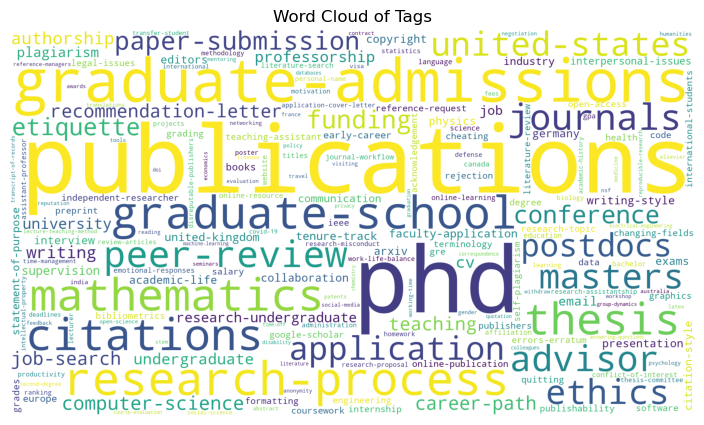

In [42]:
# Prepare data for the word cloud
tags_counts = dict(zip(tags_df["TagName"], tags_df["Count"]))

# Generate the word cloud
word_cloud = WordCloud(width=1920,
                       height=1080,
                       background_color="white",
                       colormap="viridis"
).generate_from_frequencies(tags_counts)

# Render the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud)

# Customise the word cloud
plt.axis("off")
plt.title("Word Cloud of Tags")

# Display the word cloud
plt.show()

$\rightarrow$ Since this is the Academia site, it is unsurprisingly that these words are all related to the field more or less. `publications` along with `phd` are the two most frequent tags as they cover numerous subtopics (other less frequent tags) in academia. One of people's goals in the academic field is always to have high-quality publications, so understandably, most posted enquiries are associated with the `publications` tag. Those questions came from professors, doctors of philosophy, PhD candidates, or even undergraduate students. Some questions might be related to more specific topics in `publications`, such as the research process (`research-process` tag), writing journals, a type of scholarly publication (`journals` tag), citing papers (`citations` tag), submitting papers (`paper-submission` tag), or dealing with feedback (`peer-review` tag). `phd` is a pivotal stage in academic career, this comprises of applying for PhD programs (`graduate-school` and `graduate-admissions` tags), finding supervisors (`supervision` tag) and topics for thesis (`thesis` tag), preparing substantial funding for the research program (`funding` tag). It is quite interesting to see that the most prevalent research topics are mathematics (`mathematics` tag) and computer science (`computer-science` tag - but less common than mathematics). The majority of users believe that USA (`united-states` tag) is one of the best countries to study a PhD program or to do postdoctoral research (`postdocs` tag) since USA is the home of some most prestigious research institutions in the world as analysed from the world map. Some least frequent tags are `bachelor` and `research-undergraduate` as the research work is quite uncommon for students enrolling in a bachelor's degree or in undergraduate level. The `early-career` tag is related to another unpopular notion in academia as it requires commitment, dedication, and passion to pursue a long track of research study prior to starting a career, usually 6 more years of postgraduate (2 masters years and 4 PhD years), contrasting to a potential early career in industry work.

## Potential data privacy and ethics issues

### How data privacy and ethics issues arise

We have used raw datasets to create different visualisations and have gained valuable insights into them, however, it is concerning that these might raise potential data breach issues. In particular, the downloaded datasets contain information from users on the Academia site. While the identity of each individual is hidden by separating their name from their activities, that is each user's name (`DisplayName` column) is stored in the `Users` table and their activities in other tables (their comments in `Comments` table, posts in `Posts`, upvotes and downvotes in `Votes`), it can still be identified when gathering these pieces (connecting the attributes of a row). For instance, by assessing the `Posts` dataset, if we know an acquaintance’s post (perhaps they have shown to us once), we can search for that post in the table (post title in the `Title` column and post content in the `Body` column) and find other data of it such as views (`ViewCount` attribute) or especially the user ID of the post owner (`OwnerUserId` attribute) as they all belong to the same row. This becomes more dangerous if supported by data linkage, essentially the merging of different datasets, so despite the separation of names and the generation of user IDs, these still serve as an identifier that facilitates linking between data of an individual, with the primary step is merging `Posts` table with `Users` table by matching their respective `OwnerUserId` and `Id`. Using the same approach for the subsequent merging operations, matching `UserId` in both `Comments` and `Votes` tables with `Id` in `Users` table, we have the combined table from `Users`, `Posts`, `Comments`, and `Votes` tables. As of now, it is feasible know other posts of the identified user (`Title` and `Body` columns of `Posts` table at rows having the identified `OwnerUserId`), their comments (`Text` column of `Comments` table at rows sharing the identified `UserId`), and posts they upvoted or downvoted (`VoteTypeId = 2` matches `UserId` that upvoted `PostId`, all in the `Votes` table, and the same goes for `VoteTypeId = 3` indicating downvotes). Note that `Id`, `UserId`, and `OwnerUserId` in different tables all refer to the same user ID attribute, and this ID associates with the user's name (`DisplayName` column in `Users` table). In general, by merging different datasets using a unique identifier, we can derive any attribute of an exact person (any column that constituted the merged datasets). This process is also called re-identification, an inverse of de-identification or anonymisation (hiding names).

### Consequences of re-identification

The consequences related to social aspects of re-identification cannot be neglected. With our above examples, if all questions posted (posts) of a person are known by others, they might face doubts, such as this person was asking simple and obvious questions, they were uninformed, or not as intelligent as people see them; if their comments are disclosed, they might be criticised on giving the wrong answers; or with the information about posts they downvoted, conflicts on the internet will be inevitable. Although these data do help the site's admins monitor users' behaviors and demands, if any of these are leaked, they will be at risk of being traumatised.

### Current data privacy laws and what needs to change

Currently, data privacy laws like [GDPR](https://gdpr-info.eu/) and [The Privacy Act 1988](https://www.oaic.gov.au/privacy/privacy-legislation/the-privacy-act) do address re-identification but only to a certain extent. GDPR allows "sufficient anonymisation" without explicitly stating what attributes should be removed to satisfy that, and the Privacy Act 1988 focuses on de-identification, not the prevention of re-identification. From our analysis in this section, it is a caution for these laws to be modified in such a way that directly resolves re-identification and prevents it exhaustively.

### Solutions for users' internet safety

It will be insufficient for users if they only depend on changes from the data privacy laws. Instead, each person has their own responsibility to protect themselves. Being anonymous on the internet is a wise option, that is, avoid using your real name as the username to prevent people from knowing you even if they know your `DisplayName`. Also, never show any of your activities (posts, comments, etc.) to others to hinder the data linkage or re-identification process.

## Conclusion

In summary, we loaded 8 **Academia - StackExchange** datasets (*Badges, Comments, PostHistory, PostLinks, Posts, Tags, Users, Votes*) and converted them into `.csv` format using our created function. To create our first visualisation, *The world map showing top 5 countries with most users joining the site*, we applied regular expressions (regexes) to extract the country names and count their frequencies. For the second one, *The radar chart showing Upvotes, Downvotes, Reputation for Student, Teacher, Scholar*, we calculated the average of each attribute for each type of badge. The third one is a *Bubble chart illustrating Number of Posts and Upvotes for each Question Type in 5W1H*, which was rendered from the extraction of question types utilising regexes. We leveraged regexes once again in our fourth chart, *Combo chart (line and scatter) visualising Top 3 Highest and Top 3 Lowest Days of Average Comments' Sentiment Scores*, to extract the dates of comments and compute the daily average sentiment scores of those. The last visualisation is a *Word cloud of used Tags* in which we simply used the tags and their corresponding frequencies to generate. In the final part, we addressed the concerns of data privacy from re-identification, how they arise, the downsides of current data privacy laws, and recommendations for individuals to protect themselves when joining any internet site.